In [1]:
# Most of this was adapted from https://github.com/lsst-ts/ts_salobj/blob/develop/tests/test_csc.py
import asyncio
import json
from lsst.ts import salobj
import logging

STD_TIMEOUT = 15  # timeout for command ack
LONG_TIMEOUT = 30  # timeout for CSCs to start
EVENT_DELAY = 0.1  # time for events to be output as a result of a command
NODATA_TIMEOUT = 0.1  # timeout for when we expect no new data
SHOW_LOG_MESSAGES = False


class FailedCallbackCsc(salobj.TestCsc):
    """A CSC whose do_wait command raises a RuntimeError and whose do_fault command includes a report"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.exc_msg = "do_wait raised an exception on purpose on Test-{}".format(kwargs["index"])
        self.index = kwargs["index"]
        self.log.warning = lambda x: {}
        self.log.info = lambda x: {}
        self.log.error = lambda x: {}
        self.log.debug = lambda x: {}

    async def do_wait(self, data):
        raise RuntimeError(self.exc_msg)

    async def do_fault(self, data):
        """Execute the fault command with a report, code and traceback.
        Change the summary state to State.FAULT
        """
        self.log.warning("Executing fault on Test-{}".format(self.index))
        code = 52
        report = "Report for error code for Test-{}".format(self.index,)
        traceback = "Traceback for error code for Test-{}".format(self.index,)
        self.fault(code=code, report=report, traceback=traceback)


class LogMessagesMock():
    """Triggers logMessages and errorCode events in a TestCSC """

    def __init__(self, salindex, *args, **kwargs):
        self.csc = FailedCallbackCsc(index=salindex, *args, **kwargs)
        d = salobj.Domain()
        self.r = salobj.Remote(d, 'Test', salindex)
        self.salindex = salindex

    async def set_log_level(self):
        await self.r.cmd_setLogLevel.set_start(level=logging.DEBUG, timeout=STD_TIMEOUT)

    def log_info_message(self):
        info_message = "test info message for Test-{}".format(self.salindex,)
        self.csc.log.info(info_message)

    def log_warn_message(self):
        warn_message = "test warn message for Test-{}".format(self.salindex,)
        self.csc.log.warning(warn_message)

    async def log_error_message(self):
        with salobj.assertRaisesAckError():
            await self.r.cmd_wait.set_start(duration=5, timeout=STD_TIMEOUT)

    async def printmessage(self):
        msg = await self.r.evt_logMessage.next(flush=True)
        print('\n TestCSC', self.salindex, ' | msg:', msg.message, '\nlvl:', msg.level, '\ntrace:', msg.traceback)


async def launch(salindex, debug=False):
    mock = LogMessagesMock(salindex, initial_state=salobj.State.ENABLED)
    asyncio.ensure_future(mock.csc.done_task)
    await mock.set_log_level()
    logmessages = [
        mock.log_info_message,
        mock.log_warn_message,
        mock.log_error_message
    ]

    counter = 1

    while True:
        for index, message in enumerate(logmessages):
            if index == 2:
                await message()
            else:
                message()
            if debug:
                while True:
                    try:
                        await mock.printmessage()
                    except asyncio.TimeoutError:
                        break
            counter += 1
            await asyncio.sleep(5)

def create_cscs(number):
    awaitables = []
    loop = asyncio.get_event_loop()
    for salindex in range(1, number+1):
        awaitables.append(loop.create_task(launch(salindex, True)))
    return awaitables

In [2]:
import aiohttp
import json
import asyncio
import requests
from astropy.time import Time

class clientInstance:
    
    def __init__(self):
        self.latencies = []
        self.websocket_url = ''
        self.received_messages = 0
    
    def request_token(self):
        url = 'http://love-manager-mount:8000/manager/api/get-token/'
        data = {
            'username': 'test',
            'password': 'test',
        }
        resp = requests.post(url, data = data)
        token = resp.json()['token']
        print(token)
        self.websocket_url = f'ws://love-manager-mount:8000/manager/ws/subscription?token={token}'
    
    async def handle_message_reception(self):
        """Handles the reception of messages"""
        if self.websocket:
            async for message in self.websocket:
                if message.type == aiohttp.WSMsgType.TEXT:
                    msg = json.loads(message.data)
                    if 'category' not in msg or msg['category'] != 'event' or "option" in msg and msg["option"] == "subscribe":
                        continue
                    self.received_messages = self.received_messages + 1
                    cur_time = Time.now().tai.datetime.timestamp()
                    snd_time = msg['data'][0]['data']['summaryState'][0]['private_sndStamp']['value']
                    self.latencies.append(cur_time - snd_time)
    
    async def subscribe_to_salindex(self, salindex):
        subscribe_msg = {
            'option': 'subscribe',
            'category': 'event',
            'csc': 'Test',
            'salindex': f'{salindex}',
            'stream': 'summaryState'
        }
        await self.websocket.send_str(json.dumps(subscribe_msg))
    
    async def start_ws_client(self, number):
        async with aiohttp.ClientSession() as session:
            self.websocket = await session.ws_connect(self.websocket_url)
            # async with websockets.connect(websocket_url) as websocket:
            print('started client')
            for i in range(1, N_EMITTERS+1):
                await self.subscribe_to_salindex(i)
                
            await self.handle_message_reception()


In [3]:
from lsst.ts import salobj
import asyncio

class Emitter:
    
    def __init__(self, *args, **kwargs):
        self.salindex = kwargs["salindex"]
        self.emitted_commands = 0
        
    async def create_emitter_task(self):
        d = salobj.Domain()
        r = salobj.Remote(d, 'Test', self.salindex)

        cmds = [
            r.cmd_enable,
            r.cmd_fault,
            r.cmd_standby,
            r.cmd_start,
        ]
        #while True:
        for i in range(50):
            for command in cmds:
                try:
                    await command.start()
                    self.emitted_commands = self.emitted_commands + 1
                except Exception as e:
                    print('Test CSC error:', e)
                await asyncio.sleep(0.1)
            
def create_emitters(number):
    emitters = []
    for salindex in range(1, number+1):
        emitters.append(Emitter(salindex=salindex))
    return emitters

In [4]:
# Create emitters and CSCs
N_EMITTERS = 50
loop = asyncio.get_event_loop()
csc_tasks = create_cscs(N_EMITTERS)
emitters = create_emitters(N_EMITTERS)
emitter_tasks = [loop.create_task(e.create_emitter_task()) for e in emitters]

backend_tasks = [*csc_tasks, *emitter_tasks]
# [t.cancel() for t in tasks]
# await asyncio.gather(*tasks)



In [9]:
# Create clients and listen to ws messages
N_CLIENTS = 50
loop = asyncio.get_event_loop()
clients = [clientInstance() for i in range(N_CLIENTS)]
[c.request_token() for c in clients]
client_tasks = [loop.create_task(c.start_ws_client(N_EMITTERS)) for c in clients]
await asyncio.gather(*emitter_tasks)

b4c38c0c8486ea9d7468ca0a6806a8289885385b
22869aad3187a310a1863a7f1b43b706c4e33c13
e8cc25defd53ae9f6817cc352a5157f24c9bc257
e4c80411e26c0175425516d4ed84440c0a7eda6b
2df63f91c2bf90a6dbf1f70f1bbf3bf7cb46e532
a9f68e42740807c38f0f455abb84807a09e6eb10
dc1af394a2d5a89ff98972c62e836d54ba1b409a
680777d4ea246785d67cc8eb85476632a57832f9
c17c562ec3722ae315a400a6b9d302219382bc46
240c08e43bd7c62c54a010ad3627b9b956f3a0a4
0453ee8c16769342643f472bf77bc65324683ee5
dab127c96ad7cbfe654f4a5c3a906f1dab121a24
8c5a79ef75bfde4ba0a8e20cdbf3be08ac7b89e4
7c32ff8fc328db49bc29ff7184d6e79cfadc2780
6f731b7acaa9457db11355e755853b44df3eb569
f72d1f341572985355a9c53582b6e5bb95d5c644
b6338aae419d5e0145d379715caecdf9187b5fc9
7f9c5484206e0c0713ceeb3706766ce61021d3ff
4980c1ca8bf2fb2336013b9222cfd99c785cf04d
a6cf1cf3035dcd313850e6dce0884814dde06bc1
9578b7856b77656dc4408dc681835494049b3885
1a189e2eabf601da59181a25e91dde1b457b5ad3
b22653277184042ff4c62a4f6e0f55891b662013
88bb74a1c81d150f1309ebb11f99a93c2cb7fb63
a892582892098bc2

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client
started client


# Report

In [6]:
client_msgs = [c.received_messages for c in clients]
emitter_msgs = [e.emitted_commands for e in emitters]
print(f'Sent {sum(emitter_msgs)} messages, received {sum(client_msgs)} messages ({sum(client_msgs)/len(clients)} per client)')

Sent 9950 messages, received 392687 messages (7853.74 per client)


## Latency

In [7]:
import statistics

latencies = [[l*1000 for l in c.latencies] for c in clients]
avg_latencies = [statistics.mean(l) for l in latencies]
median_latencies = [statistics.median(l) for l in latencies]
avg_latency = statistics.mean(avg_latencies)
median_latency = statistics.median(median_latencies)

print(f'Average message latency: {round(avg_latency)}ms')
print(f'Median message latency: {round(median_latency)}ms')


Average message latency: 1772ms
Median message latency: 1040ms


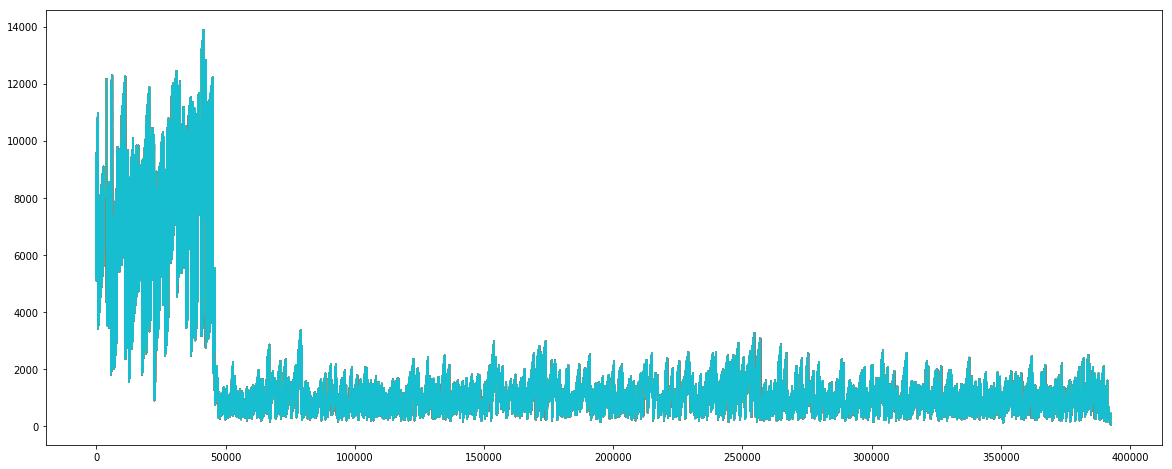

In [8]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
for l in latencies:
    plt.plot(range(len(l)), l)

In [ ]:
[t.cancel() for t in [*backend_tasks, *client_tasks]]
#[t.cancel() for t in [*client_tasks]]
for task in asyncio.Task.all_tasks():
    task.cancel()

In [10]:
import numpy as np
sum(np.array(latencies[0])-np.array(latencies[5]))

0.0